##### Author: Chibueze Ukachi
##### This notebook goes through the Data Analysis pipeline from descriptive analysis to Machine Learning and visualisation 

- Source: https://pythonspot.com/matplotlib-bar-chart/. The modifications were made to **part 5** to make the code used for drawing the histogram have the appropriate legends for train/test split: 

- Source: http://scikit-learn.org/stable/modules/feature_selection.html. No modifications were made to code in **part 7** which was used to highlight important features for the  ML algorithm

- Source: http://scikit-learn.org/stable/auto_examples/neighbors/plot_classification.html#sphx-glr-auto-examples-neighbors-plot-classification-py. Modifications were made to code in **part 10** to draw the decision boundaries for a five class problem. Also, changes to the min/max indices and graph positioning


In [1]:
# Load libraries

%matplotlib inline

import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import seaborn as sn
import numpy as np # Math
import pandas as pd
import sklearn.neighbors, sklearn.ensemble
from sklearn.ensemble import ExtraTreesClassifier

import time
from time import process_time

from sklearn.model_selection import train_test_split
from sklearn import preprocessing, neighbors, datasets, metrics
from sklearn.metrics import confusion_matrix, accuracy_score

from sklearn.model_selection import cross_val_score, GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB


import warnings
warnings.filterwarnings('ignore')

import sklearn.neighbors, sklearn.linear_model, sklearn.ensemble, sklearn.naive_bayes 


## Supervised Machine Learning Classification

This notebook uses the features extracted in the **ReadyFeatureExtraction_Uniform** csv file to perform classify different application layer protocols. 

1. Import and do high level verification check of dataset
2. Transform data to scikit-learn friendly format
3. Compute 80/20 train test split and perform classification
4. Cross validation to verify it
5. Plot train/test split graph 
6. Confusion matrix
7. Feature importances
8. Hyper-parameter tuning
9. Drawing mesh grid
10. Draw decision boundaries
11. Extension: ML with shallow packet inspection

### 1. Import data and retrieve high level details 


In [2]:
#import cleaned data set
df = pd.read_csv("Data/ReadyFeatureExtraction_Uniform.csv",index_col=0) 
#uncomment to use the non-uniform dataset. Note that it is prone to overfitting
#df = pd.read_csv("ReadyFeatureExtraction_NonUniform.csv",index_col=0) 
print(df.shape)

(7275, 6)


In [3]:
df.head(5)

,avg_delay,avg_byte_rate,avg_packet_rate,avg_packet_size,Protocol,NumericalProtocol
0,0.0734,0.373261,0.162288,2.3,Telnet,2
1,0.0283,0.480868,0.343477,1.4,Telnet,2
2,0.0835,0.348109,0.105487,3.3,Telnet,2
3,0.0924,0.775505,0.267415,2.9,Telnet,2
4,0.1122,0.632847,0.253139,2.5,Telnet,2


In [4]:
df['Protocol'].unique()

array(['Telnet', 'Quake3', 'DNS', 'csa', 'csi'], dtype=object)

In [5]:
df['NumericalProtocol'].unique()

array([2, 1, 0, 3, 4])

In [6]:
#high level stats overview 
df.describe()

,avg_delay,avg_byte_rate,avg_packet_rate,avg_packet_size,NumericalProtocol
count,7275.000000,7275.000000,7275.000000,7275.000000,7275.000000
mean,0.100946,2.522336,0.086933,69.398735,2.000000
std,0.040371,4.026437,0.105519,73.676541,1.414311
min,0.019400,-0.059665,-0.000228,1.000000,0.000000
25%,0.081800,0.218368,0.025857,27.300000,1.000000
50%,0.092800,0.730842,0.026435,43.600000,2.000000
75%,0.109900,1.208330,0.147820,64.400000,3.000000
max,1.011300,25.733402,0.589797,262.000000,4.000000


In [7]:
df['Protocol'].value_counts()

csi       1455
Quake3    1455
Telnet    1455
DNS       1455
csa       1455
Name: Protocol, dtype: int64

In [8]:
df = df.reindex(np.random.permutation(df.index))
df.shape

(7275, 6)

In [9]:
df.head()

,avg_delay,avg_byte_rate,avg_packet_rate,avg_packet_size,Protocol,NumericalProtocol
1841,0.1045,10.374328,0.163891,63.3,Quake3,1
323,0.1026,0.276817,0.138408,2.0,Telnet,2
2007,0.0903,10.171824,0.163797,62.1,Quake3,1
3665,0.0942,-0.053266,-0.000228,233.9,DNS,0
5172,0.0897,1.071266,0.025939,41.3,csa,3



### 2. Organised the train/test split and perform relevant scaling

1. X_train matrix contains the training data
2. y_train vector contains the training labels
3. X_test matrix contains the test data
4. y_test vector contains the test labels

### No packet inspection (uses timing and rate data)

In [10]:
X = df[['avg_delay','avg_packet_rate']]
#X = df[['avg_packet_rate']]
y = df[['NumericalProtocol']]


In [11]:
X.head()

,avg_delay,avg_packet_rate
1841,0.1045,0.163891
323,0.1026,0.138408
2007,0.0903,0.163797
3665,0.0942,-0.000228
5172,0.0897,0.025939


In [12]:
y.head()

,NumericalProtocol
1841,1
323,2
2007,1
3665,0
5172,3


### 3. Does a 80/20 train split then tries five different machine learning algorithms

In [13]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print("The shape of the input features is:", X.shape)
print("The shape of the output is:", y.shape)
#test/train sizes
tt_sizes ={
    'X_train size' : X_train.shape,
    'X_test size'  : X_test.shape,
    'y_train size' : y_train.shape,
    'y_test size=' : y_test.shape   
}
print(tt_sizes)

The shape of the input features is: (7275, 2)
The shape of the output is: (7275, 1)
{'X_train size': (5820, 2), 'X_test size': (1455, 2), 'y_train size': (5820, 1), 'y_test size=': (1455, 1)}


In [14]:
#scaling between 0 and 1
min_max_scaler = preprocessing.MinMaxScaler()

X_train = min_max_scaler.fit_transform(X_train)
X_test = min_max_scaler.transform(X_test)

In [15]:
X_train.shape

(5820, 2)

In [16]:
train_accuracy = []
test_accuracy = []
execution_time = []
models = [KNeighborsClassifier(),
          RandomForestClassifier(),
          LinearSVC(),
          LogisticRegression(),
          MultinomialNB()]
         
for clf in models:
    t_start = time.process_time()
    clf.fit(X_train, y_train)
    train_pred = clf.predict(X_train)
    test_pred = clf.predict(X_test)
    train_accuracy.append(round(100*float(accuracy_score(y_train, train_pred)),2))
    test_accuracy.append(round(100*float(accuracy_score(y_test, test_pred)),2))
                         
    execution_time.append(round((process_time() - t_start),2))
print('Train accuracy:', train_accuracy )
print('Test accuracy: ',test_accuracy)
print('Execution time:', execution_time)

Train accuracy: [82.96, 98.21, 70.74, 69.81, 59.81]
Test accuracy:  [76.91, 76.08, 72.37, 71.75, 58.49]
Execution time: [0.03, 0.12, 0.07, 0.07, 0.01]


#### 4. Using cross validation to check answer pre hyper tuning ( k = 5 )

In [17]:
clf = models[0]
scores = cross_val_score(clf, X, y, cv=5)
print("The accuracy is: %0.25", scores.mean())
print("The margin is: +/- %0.3f", (scores.std() * 2))

The accuracy is: %0.25 0.744054982818
The margin is: +/- %0.3f 0.0173348539056


#### 5. Plot graph for part 3

In [18]:
def plot_train_test(train_acc,test_acc,tune=None):
# This graph is based the example on scikit-learn example as stated in the header
    n_groups = 5

    # create plot
    fig, ax = plt.subplots()
    index = np.arange(n_groups)
    bar_width = 0.35
    opacity = 0.8

    rects1 = plt.bar(index, train_acc, bar_width,
                     alpha=opacity,
                     color='b',
                     label='Training')

    rects2 = plt.bar(index + bar_width, test_acc, bar_width,
                     alpha=opacity,
                     color='g',
                     label='Testing')

    plt.xlabel('Train/Test split')
    plt.ylabel('Training/Testing accuracy')
    plt.title('Training and testing accuracy for five supervised learning algorithms')
    plt.xticks(index + bar_width, ('KNN', 'RForest', 'SVM', 'LogisReg','NBayes'))
    plt.legend()

    plt.show()
    #store the data distribution image as a png file
    if tune == "Normal":
        fig.savefig('Data/AccuracyGraphsNoHyp.png')
    else:
        #store the data distribution image as a png file
        fig.savefig('Data/AccuracyGraphsWithHyp.png')
        

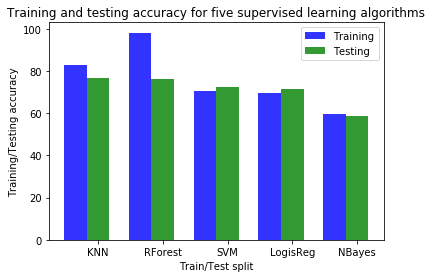

In [19]:
plot_train_test(train_accuracy,test_accuracy,tune="Normal")

### 6. Compute and draws the confusion matrix 

In [20]:
from scipy.stats import itemfreq
print(len(y_test))
itemfreq(y_test)

1455


array([[  0, 303],
       [  1, 273],
       [  2, 291],
       [  3, 285],
       [  4, 303]])

In [21]:
print(len(test_pred))
itemfreq(test_pred)

1455


array([[  0, 314],
       [  1, 529],
       [  3, 612]])

In [22]:
cm_df =  confusion_matrix(y_test, test_pred)
cm_df

array([[303,   0,   0,   0,   0],
       [  1, 269,   0,   3,   0],
       [  0, 260,   0,  31,   0],
       [  6,   0,   0, 279,   0],
       [  4,   0,   0, 299,   0]])

In [23]:
prot = df['Protocol'].unique()
prot

array(['Quake3', 'Telnet', 'DNS', 'csa', 'csi'], dtype=object)

In [24]:
num_prot = df['NumericalProtocol'].unique()
num_prot

array([1, 2, 0, 3, 4])

In [25]:
prot_name_map =  np.sort(np.stack([prot,num_prot]),axis=1)
prot_name_map

array([['DNS', 'Quake3', 'Telnet', 'csa', 'csi'],
       [0, 1, 2, 3, 4]], dtype=object)

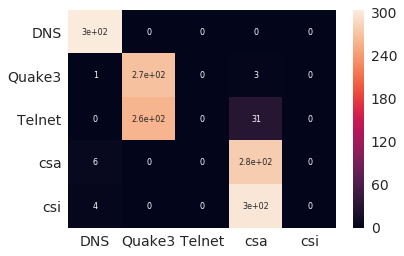

In [26]:
sn.set(font_scale=1.4)
heatmap = sn.heatmap(cm_df, annot=True,annot_kws={"size": 8}, yticklabels=prot_name_map[:1][0],
           xticklabels=prot_name_map[:1][0])# font size

fig = heatmap.get_figure()
fig.savefig("Data/Confusionmatrix.png")

### 7. This highlights the features that are most important to the ML algorithm
**The code for retrieving important features is based on the example in scikit-learn  as stated in the header**

In [27]:
# fit an Extra Trees model to the data
model = ExtraTreesClassifier()
model.fit(X, y)
# display the relative importance of each attribute
print(model.feature_importances_)

[ 0.20569764  0.79430236]


In [28]:
imp_features = model.feature_importances_
max_pos = np.argmax(imp_features)
min_pos = np.argmin(imp_features)

print("The most important feature is %s , with a score of %.3f:" % (X.columns[max_pos], 
                                                                    round(imp_features[max_pos],3)))
print("The least important feature is %s , with a score of %f:" % (X.columns[min_pos], 
                                                                   round(imp_features[min_pos],3)))

The most important feature is avg_packet_rate , with a score of 0.794:
The least important feature is avg_delay , with a score of 0.206000:


In [29]:
type(X.values)

numpy.ndarray

### 8. Hyper parameter tuning for KNN

In [30]:
#these are some of the numerous hyper-parameters that can be tuned
#by default the weight is uniform meaning the closest points have the same voting power as further ones
#bestWeight = 'uniform'
bestWeight = 'distance'

clf = models[0]
#Hyper Parameters combinations to check
params = {'n_neighbors':[2,5,9,15,20,25,30,35,40,45,50],
          'n_jobs':[-1]}

#Making models with the hyper parameters in the params dict above
model = GridSearchCV(clf, param_grid=params, n_jobs=-1)
#Learning weights
model.fit(X_train,y_train)

print("The best hyper parameters are:\n",model.best_params_)


The best hyper parameters are:
 {'n_jobs': -1, 'n_neighbors': 20}


In [31]:
train_accuracy = []
test_accuracy = []
execution_time = []
hyp_models = [KNeighborsClassifier(weights=bestWeight,
                               n_neighbors=model.best_params_['n_neighbors']), 
          RandomForestClassifier(),
          LinearSVC(), 
          LogisticRegression(),
          MultinomialNB()]
         
for clf in hyp_models:
    t_start = time.process_time()
    clf.fit(X_train, y_train)
    train_pred = clf.predict(X_train)
    test_pred = clf.predict(X_test)
    train_accuracy.append(round(100*float(accuracy_score(y_train, train_pred)),2))
    test_accuracy.append(round(100*float(accuracy_score(y_test, test_pred)),2))
                         
    execution_time.append(round((process_time() - t_start),2))
print('Train accuracy:', train_accuracy )
print('Test accuracy: ',test_accuracy)
print('Execution time:', execution_time)

Train accuracy: [100.0, 98.14, 70.74, 69.81, 59.81]
Test accuracy:  [76.08, 76.98, 72.37, 71.75, 58.49]
Execution time: [0.05, 0.07, 0.05, 0.06, 0.01]


#### 9. Using cross validation to check answer post hyper tuning ( k = 5 )

In [32]:
clf = hyp_models[0]
scores = cross_val_score(clf, X, y, cv=5)
print("The accuracy is: %0.25", scores.mean())
print("The margin is: +/- %0.3f", (scores.std() * 2))

The accuracy is: %0.25 0.750103092784
The margin is: +/- %0.3f 0.0199118284121


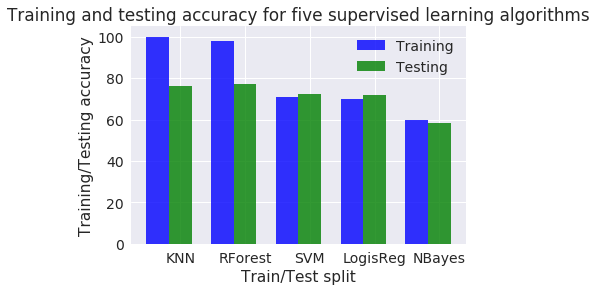

In [33]:
plot_train_test(train_accuracy,test_accuracy,tune="HyperParameter")

#### 10. This color mesh shows the boundaries used for the classification for each component 

##### The code showing the decision boundaries is based on the example on scikit-learn as stated in the header

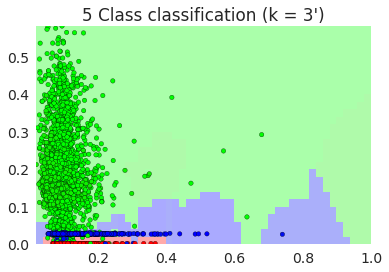

In [34]:
h = .02  # step size in the mesh
n_neighbors = 3

cmap_light = ListedColormap(['#FFAAAA', '#AFFAAA', '#AAFFAA', '#AAAFFA', '#AAAAFF'])
cmap_bold = ListedColormap(['#FF0000', '#0FF000', '#00FF00', '#000FF0', '#0000FF'])

X = X.values
y = np.squeeze(y.values)


# we create an instance of Neighbours Classifier and fit the data.
clf = neighbors.KNeighborsClassifier(n_neighbors,  weights=bestWeight)

clf.fit(X, y)

# Plot the decision boundary. For that, we will assign a color to each
# point in the mesh [x_min, x_max]x[y_min, y_max].
x_min, x_max = np.min(X,axis=0)[0], np.max(X,axis=0)[0] 
y_min, y_max = np.min(X,axis=0)[1],np.max(X,axis=0)[1] 

xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                     np.arange(y_min, y_max, h))
Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])

# Put the result into a color plot
Z = Z.reshape(xx.shape)
fig = plt.figure()
plt.figure()
plt.pcolormesh(xx, yy, Z, cmap=cmap_light)

# Plot also the training points
plt.scatter(X[:, 0], X[:, 1], c=y, cmap=cmap_bold,
            edgecolor='k', s=20)
plt.xlim(xx.min(), xx.max())
plt.ylim(yy.min(), yy.max())
plt.title("5 Class classification (k = %i')" % (n_neighbors))

plt.show()

In [35]:
cm_df =  confusion_matrix(y_test, test_pred)


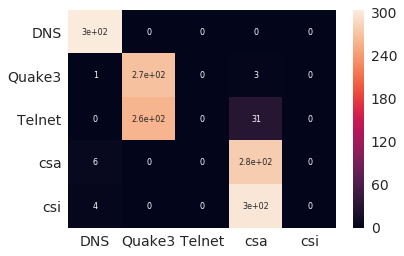

In [36]:

sn.set(font_scale=1.4)
heatmap = sn.heatmap(cm_df, annot=True,annot_kws={"size": 8}, yticklabels=prot_name_map[:1][0],
           xticklabels=prot_name_map[:1][0])# font size

fig = heatmap.get_figure()
fig.savefig("Data/Confusionmatrix.png")

In [37]:
#import cleaned data set
df = pd.read_csv("Data/ReadyFeatureExtraction_Uniform.csv",index_col=0) 
df = df.reindex(np.random.permutation(df.index))
df.shape

(7275, 6)

### 11. Shallow Packet Inspect Inspection (uses timing, size and rate)

In [38]:
X = df[['avg_delay','avg_byte_rate','avg_packet_rate','avg_packet_size']]
y = df[['NumericalProtocol']]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
#scaling between 0 and 1
min_max_scaler = preprocessing.MinMaxScaler()

X_train = min_max_scaler.fit_transform(X_train)
X_test = min_max_scaler.transform(X_test)


In [39]:
train_accuracy = []
test_accuracy = []
execution_time = []
models = [KNeighborsClassifier(),
          RandomForestClassifier(),
          LinearSVC(),
          LogisticRegression(),
          MultinomialNB()]
         
for clf in models:
    t_start = time.process_time()
    clf.fit(X_train, y_train)
    train_pred = clf.predict(X_train)
    test_pred = clf.predict(X_test)
    train_accuracy.append(round(100*float(accuracy_score(y_train, train_pred)),2))
    test_accuracy.append(round(100*float(accuracy_score(y_test, test_pred)),2))
                         
    execution_time.append(round((process_time() - t_start),2))
print('Train accuracy:', train_accuracy )
print('Test accuracy: ',test_accuracy)
print('Execution time:', execution_time)

Train accuracy: [99.95, 100.0, 97.66, 95.45, 79.4]
Test accuracy:  [100.0, 100.0, 98.35, 96.01, 77.94]
Execution time: [0.04, 0.05, 0.03, 0.08, 0.01]


In [40]:
clf = models[0]
scores = cross_val_score(clf, X, y, cv=5)
print("The accuracy is: %0.3f" % (scores.mean()))
print("The margin is: +/- %0.3f"%(scores.std() * 2))

The accuracy is: 1.000
The margin is: +/- 0.000


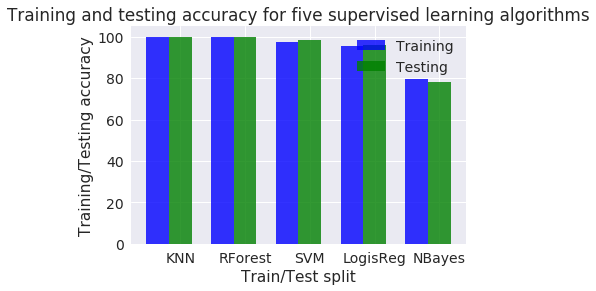

In [41]:
plot_train_test(train_accuracy,test_accuracy,tune="Normal")